In [1]:
! pip install geopandas

In [2]:
! wget https://data.lacity.org/api/views/wjz9-h9np/rows.csv?accessType=DOWNLOAD

--2020-09-14 21:44:10--  https://data.lacity.org/api/views/wjz9-h9np/rows.csv?accessType=DOWNLOAD
Resolving data.lacity.org (data.lacity.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.lacity.org (data.lacity.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD.1’

rows.csv?accessType     [     <=>            ]   1.34G  4.70MB/s    in 5m 40s  

2020-09-14 21:49:50 (4.03 MB/s) - ‘rows.csv?accessType=DOWNLOAD.1’ saved [1438347754]



In [3]:
! wget https://www2.census.gov/geo/tiger/TIGER2017//STATE/tl_2017_us_state.zip
! unzip tl_2017_us_state.zip


--2020-09-14 21:49:50--  https://www2.census.gov/geo/tiger/TIGER2017//STATE/tl_2017_us_state.zip
Resolving www2.census.gov (www2.census.gov)... 23.62.212.78, 2600:1402:d800:1aa::208c, 2600:1402:d800:184::208c
Connecting to www2.census.gov (www2.census.gov)|23.62.212.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘tl_2017_us_state.zip.1’

tl_2017_us_state.zi     [   <=>              ]   8.85M  17.3MB/s    in 0.5s    

2020-09-14 21:49:51 (17.3 MB/s) - ‘tl_2017_us_state.zip.1’ saved [9284383]

Archive:  tl_2017_us_state.zip
replace tl_2017_us_state.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: tl_2017_us_state.cpg    
replace tl_2017_us_state.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tl_2017_us_state.dbf    
replace tl_2017_us_state.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: tl_2017_us_state.prj    
replace tl_2017_us_state.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  infla

In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import math
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
import pickle
import seaborn as sns
import sys
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pd.set_option('max_rows', 500)
np.set_printoptions(threshold=sys.maxsize)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
states = gpd.read_file('/content/tl_2017_us_state.shp', crs="EPSG:4326")

In [6]:
states.head()

REGION  ...                                           geometry
0      3  ...  POLYGON ((-81.74725 39.09538, -81.74635 39.096...
1      3  ...  MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ...
2      2  ...  POLYGON ((-91.18529 40.63780, -91.17510 40.643...
3      2  ...  POLYGON ((-96.78438 46.63050, -96.78434 46.630...
4      3  ...  POLYGON ((-77.45881 39.22027, -77.45866 39.220...

[5 rows x 15 columns]

We load the data as json instead of geojson because some table manipulations can cause the geodataframe to break, so turn it into a geodataframe at the end

In [7]:
# Use this code to get data via API. 
# Register to get more than 1000 records at a time
# r = requests.get('https://data.lacity.org/resource/wjz9-h9np.json?$limit=50000', auth=('', ''))
# df = pd.DataFrame(r.json())

In [8]:
df = pd.read_csv('/content/rows.csv?accessType=DOWNLOAD', low_memory=False)

In [9]:
df.head()

Ticket number  Issue Date  ...  Color Description Body Style Description
0    1103341116  12/21/2015  ...                NaN                    NaN
1    1103700150  12/21/2015  ...                NaN                    NaN
2    1104803000  12/21/2015  ...                NaN                    NaN
3    1104820732  12/26/2015  ...                NaN                    NaN
4    1105461453  09/15/2015  ...                NaN                    NaN

[5 rows x 22 columns]

From inspection of the first five records there are some columns containing NaNs and Latitude and Longitude are not in degrees and also contain placeholder values.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10636222 entries, 0 to 10636221
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Ticket number           object 
 1   Issue Date              object 
 2   Issue time              float64
 3   Meter Id                object 
 4   Marked Time             float64
 5   RP State Plate          object 
 6   Plate Expiry Date       float64
 7   VIN                     object 
 8   Make                    object 
 9   Body Style              object 
 10  Color                   object 
 11  Location                object 
 12  Route                   object 
 13  Agency                  float64
 14  Violation code          object 
 15  Violation Description   object 
 16  Fine amount             float64
 17  Latitude                float64
 18  Longitude               float64
 19  Agency Description      object 
 20  Color Description       object 
 21  Body Style Description  objec

In [11]:
df.describe()

Issue time    Marked Time  ...      Latitude     Longitude
count  1.063174e+07  343645.000000  ...  1.063622e+07  1.063622e+07
mean   1.196782e+03    1059.125505  ...  5.533343e+06  1.595283e+06
std    4.749732e+02     226.249537  ...  2.861511e+06  1.886627e+06
min    0.000000e+00       1.000000  ...  0.000000e+00  0.000000e+00
25%    9.090000e+02     914.000000  ...  6.421973e+06  1.822259e+06
50%    1.153000e+03    1040.000000  ...  6.452185e+06  1.841987e+06
75%    1.505000e+03    1200.000000  ...  6.475231e+06  1.858206e+06
max    2.359000e+03    2400.000000  ...  4.042322e+09  4.042322e+09

[8 rows x 7 columns]

In [12]:
# Percentage of missing data
df.isna().sum()/len(df)*100

Ticket number              0.000000
Issue Date                 0.017835
Issue time                 0.042111
Meter Id                  74.263521
Marked Time               96.769107
RP State Plate             0.013445
Plate Expiry Date          9.326159
VIN                       99.846665
Make                       0.157594
Body Style                 0.126483
Color                      0.112728
Location                   0.032982
Route                      0.767697
Agency                     0.017140
Violation code             0.270331
Violation Description      0.572741
Fine amount                0.215123
Latitude                   0.000066
Longitude                  0.000066
Agency Description        92.609265
Color Description         92.878026
Body Style Description    92.674777
dtype: float64

In [13]:
# Function to prepare the time values so that they can be parsed
def time_padding(time):
  '''Adds extra zeros until there are 4 characters'''
  time = str(int(time))
  return '0'*(4-len(time)) + time

In [14]:
df['Issue time'].fillna(0, inplace=True)

# Apply padding to Issue_time
df['Issue time'] = df['Issue time'].apply(time_padding)
df['Datetime'] = pd.to_datetime(df['Issue Date'] + ' ' + df['Issue time'], 
                                format='%m/%d/%Y %H%M')
df = df.drop(['Issue Date', 'Issue time'], axis=1)

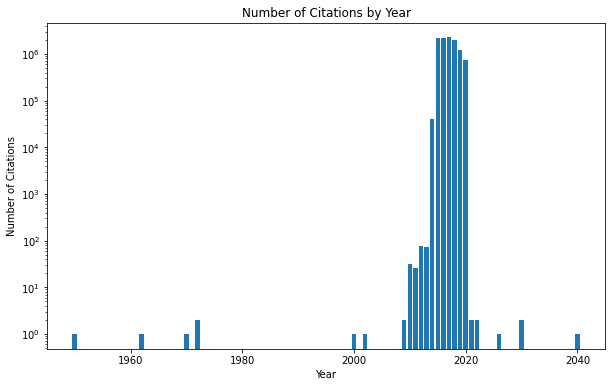

In [15]:
plot_count = df['Datetime'].dt.year.value_counts().sort_index()
plt.figure(figsize=(10 ,6))
plt.bar(plot_count.index, plot_count)
plt.title('Number of Citations by Year')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.yscale('log')
plt.show()

Citations before 2008 and after 2020 are likely erroneous

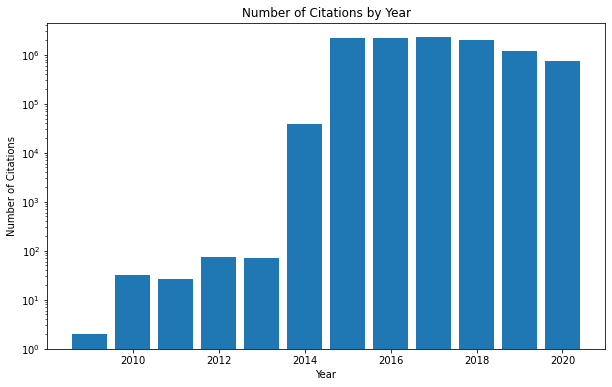

In [16]:
mask = (df['Datetime'].dt.year > 2008) & (df['Datetime'].dt.year <= 2020)
plot_count = df.loc[mask,'Datetime'].dt.year.value_counts().sort_index()
plt.figure(figsize=(10 ,6))
plt.bar(plot_count.index, plot_count)
plt.title('Number of Citations by Year')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.yscale('log')
plt.show()

In [17]:
df = df.loc[mask].reset_index(drop=True)

In [18]:
df.head()

Ticket number Meter Id  ...  Body Style Description            Datetime
0    1103341116      NaN  ...                     NaN 2015-12-21 12:51:00
1    1103700150      NaN  ...                     NaN 2015-12-21 14:35:00
2    1104803000      NaN  ...                     NaN 2015-12-21 20:55:00
3    1104820732      NaN  ...                     NaN 2015-12-26 15:15:00
4    1105461453      NaN  ...                     NaN 2015-09-15 01:15:00

[5 rows x 21 columns]

In [19]:
df['Meter Id'].unique()[:100]

array([nan, 'WF55', 'WF54', 'WF177A', 'WF99', 'WF100', 'CB1463B', 'VH73',
       'VH220', 'VH14', '25', '45', '13', 'WF192', 'BF430', 'L80',
       'HO6630', 'HO6632', 'HO966', 'HO133', 'L233', 'L16940', 'LT72',
       'CC1235', 'CB3168', 'SW235', 'V6127', 'V27610', 'V117', 'V6125',
       'V74', 'V102', 'V6123', 'V166', 'V212', 'V207', 'V6126', 'V6128',
       'V111', 'PW442', 'OS164', 'OS142', 'OS467', 'OS162', 'OS570',
       'OS566', 'OS558', 'OS697', 'WS512', '11', 'WW2533', '36', 'WW303',
       'SVV345', '03', 'WU490', 'WU642', 'WU985A', 'SA117', 'SA115',
       'SA131', 'CB3695', 'WA654', 'WA663', 'VW303', 'VW302', 'VW607',
       'WA749', 'WA883', 'WA891', 'WA836', 'WA907', 'WA1324', 'WA1344',
       'WA1283', 'WA1278', 'WA1291', 'WA687', 'PR267', 'MM785', '30',
       'BF673', 'BF575', 'BF593A', 'BF697', 'SG72', 'SG87', 'SG99',
       'SG98', 'SG103', 'SG108', 'SG109', 'SG229', 'SG146', 'L213', 'L99',
       'L104', 'SVV52', 'SVV77', 'HW278'], dtype=object)

The 'Meter Id' column is missing nearly 75% of its data and includes 



In [20]:
df['Marked Time'].unique()[:100]

array([  nan, 1122., 1145., 1124., 1130.,  820., 1817., 1110.,  944.,
        856., 1326.,  814.,  813.,  822.,  831.,  833.,  838.,  842.,
       1000.,  950.,  835.,  930.,  900.,  816.,  800.,  803.,  804.,
       1256.,  910.,  931.,  941., 1033., 1058., 1012., 1005., 1255.,
       1300., 1305., 1310., 1500., 1700., 1120., 1134., 1040., 1210.,
        955.,  940., 1119., 1057., 1101., 1104., 1113., 1242., 1254.,
       1357., 1346., 1447., 1458., 1545., 1555., 1630., 1035., 1045.,
       1105., 1100., 1313., 1311., 1230., 1240., 1316., 1050., 1054.,
       1109., 1206., 1218., 1014., 1021., 1022., 1150., 1055., 1009.,
       1328.,  855.,  854.,  925.,  933.,  810., 1013., 1007., 1131.,
       1155., 1200., 1039., 1037., 1115., 1220., 1140.,  839.,  849.,
        853.])

In [21]:
df.loc[df['Marked Time'].notna(), 'Marked Time'].apply(time_padding).unique()[:100]

array(['1122', '1145', '1124', '1130', '0820', '1817', '1110', '0944',
       '0856', '1326', '0814', '0813', '0822', '0831', '0833', '0838',
       '0842', '1000', '0950', '0835', '0930', '0900', '0816', '0800',
       '0803', '0804', '1256', '0910', '0931', '0941', '1033', '1058',
       '1012', '1005', '1255', '1300', '1305', '1310', '1500', '1700',
       '1120', '1134', '1040', '1210', '0955', '0940', '1119', '1057',
       '1101', '1104', '1113', '1242', '1254', '1357', '1346', '1447',
       '1458', '1545', '1555', '1630', '1035', '1045', '1105', '1100',
       '1313', '1311', '1230', '1240', '1316', '1050', '1054', '1109',
       '1206', '1218', '1014', '1021', '1022', '1150', '1055', '1009',
       '1328', '0855', '0854', '0925', '0933', '0810', '1013', '1007',
       '1131', '1155', '1200', '1039', '1037', '1115', '1220', '1140',
       '0839', '0849', '0853', '0805'], dtype=object)

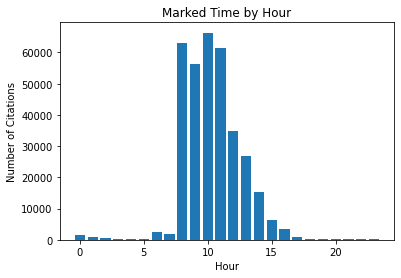

In [22]:
time_counts = pd.to_datetime(df.loc[df['Marked Time'].notna(), 'Marked Time'].apply(time_padding), format='%H%M', errors='coerce').dt.hour.value_counts()
plt.bar(time_counts.index, time_counts)
plt.title('Marked Time by Hour')
plt.ylabel('Number of Citations')
plt.xlabel('Hour')
plt.show()

The 'Marked Time' column is missing 96% of its data. It consists of time stamps in a 24 hr format.

In [23]:
state_plate_df = df['RP State Plate'].value_counts().reset_index()
state_plate_df.columns = ['state', 'plate_count']

In [24]:
state_plate_df.head(10)

state  plate_count
0    CA      9905557
1    AZ        94845
2    TX        67251
3    NV        62743
4    FL        46999
5    WA        42012
6    IL        29930
7    OR        29687
8    CO        26970
9    NY        19661

In [25]:
# Geopandas can calculate distance of nearby objects but distance objects
# need a different formula
def distance(source , destination): 
  '''Haversine formula for distance on a sphere in miles'''
  lat1, lon1 = source [0],source [1]
  lat2, lon2 = destination[0],destination[1]
  radius = 3956 # mi
  dlat = math.radians(lat2-lat1)
  dlon = math.radians(lon2-lon1)
  a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
      * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  d = radius * c
  return d

In [26]:
# Formula to calculate distance between California and other states
def state_dist(state):
  '''Formula to calculate distance between CA and other states'''
  state_intersect = set(df['RP State Plate']).intersection(set(states.STUSPS))
  calif_coords = states.loc[states.STUSPS == 'CA', ['INTPTLAT', 'INTPTLON']].values.astype(float)[0]
  calif_dist_dict = { state.STUSPS : distance(calif_coords,(float(state.INTPTLAT),float(state.INTPTLON))) for ind, state in states.iterrows()}
  if state in state_intersect:
    return calif_dist_dict[state]
  else:
    return np.nan

In [27]:
state_plate_df['dist_ca'] = state_plate_df.state.apply(state_dist).round(1)
state_plate_df_inters = state_plate_df.loc[state_plate_df[state_plate_df.dist_ca.notna()].index]
state_plate_df_inters.head()

state  plate_count  dist_ca
0    CA      9905557      0.0
1    AZ        94845    489.3
2    TX        67251   1218.5
3    NV        62743    218.6
4    FL        46999   2221.6

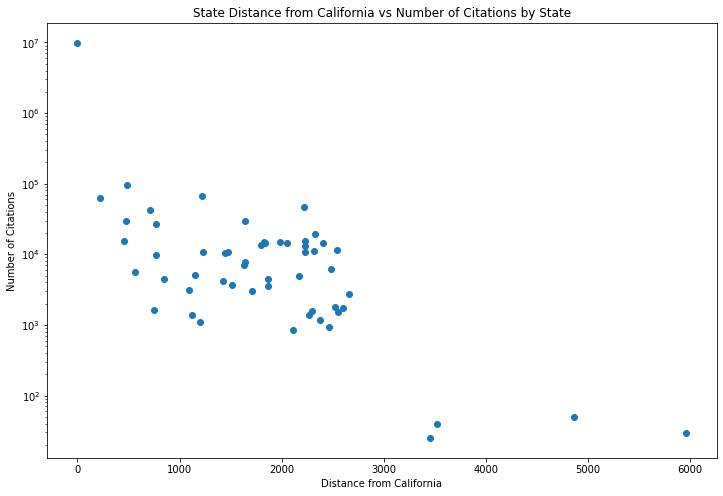

In [28]:
# Plot of distance between state of citation vehicle and CA vs number of citations
plt.figure(figsize=(12,8))
plt.scatter(state_plate_df.loc[state_plate_df_inters.index].dist_ca, 
            state_plate_df.loc[state_plate_df_inters.index, 'plate_count'])
plt.yscale('log')
plt.title('State Distance from California vs Number of Citations by State')
plt.ylabel('Number of Citations')
plt.xlabel('Distance from California')
plt.show()

The graph with the a log scale for the number of citations is roughly linear, so it would make sense to check the correlation of the log of the number of citations.

In [29]:
# Correlation table with log citation count
spdi_log = state_plate_df_inters.copy()
spdi_log['log_plate_count'] = spdi_log['plate_count'].apply(np.log)
spdi_log.corr().round(3)

plate_count  dist_ca  log_plate_count
plate_count            1.000   -0.247            0.502
dist_ca               -0.247    1.000           -0.709
log_plate_count        0.502   -0.709            1.000

In [30]:
# State/territory most distant from California
spdi_log.loc[spdi_log.dist_ca.idxmax()]

state                  GU
plate_count            29
dist_ca            5962.3
log_plate_count    3.3673
Name: 68, dtype: object

We find that the distance between the state where the car is from and the log of the number of citations of that state have a correlation of -0.71. So closer the state, the higher the number of citations, with California having 9.8M citations and Guam being 6K miles away and having only 29 citations total.

In [31]:
df.loc[df['Plate Expiry Date'].notna(),'Plate Expiry Date'].astype(int).unique()[:100]

array([200304, 201512, 201503, 200316, 201507, 201605, 201602, 201701,
       201511, 201607, 201611, 201502, 201606, 201509, 201603, 201610,
       201601, 201510, 201506, 201604, 201608, 201508, 201504, 201505,
       201407, 201609, 201702, 201412, 201212, 200815, 201403, 201410,
       201501, 201905, 201612, 201408, 200906,      1,      8, 201712,
       201903, 201102,      3,      4,     12,      9,      6,      5,
       201304,      2,     11,      7,     10, 201706, 201206, 201307,
       201302, 200106, 201901, 201709, 200104, 201708, 200505, 201411,
       201704, 201110, 201101, 200105, 201308, 201106, 201705, 201409,
       201703, 201108, 201710, 201902, 201111, 201402, 209912, 201909,
       201707, 201404, 201405, 200103, 201309, 209009, 201209, 200615,
       201205, 200514, 201211, 201010, 200710, 200810, 200916, 200616,
       200716, 201311, 201711, 201103])

Plate expiry dates seem to be in the format 'year''month', but there are many examples of dates into the far future ie 2099 and months that go beyond 12. I'll parse the dates but add them as a separate column

The top state plates refer to California and neighboring states but there are a few anomalies like MX (probably referring to Mexico), AB (Alberta, Canada), and TT (tow truck).
http://www.nyc.gov/html/dof/html/pdf/faq/stars_codes.pdf

In [32]:
df['Plate Expiry Date Parsed'] = pd.to_datetime(df['Plate Expiry Date'],format='%Y%m', errors='coerce')

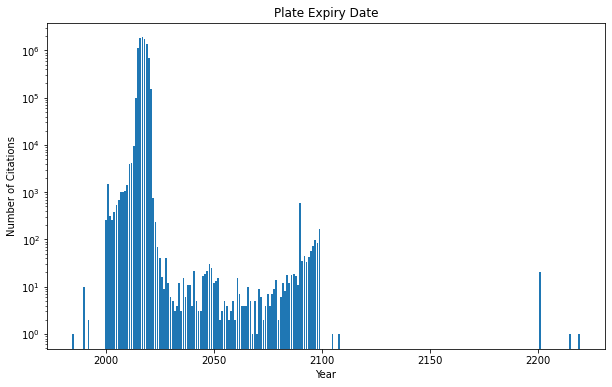

In [33]:
plate_expiry = df['Plate Expiry Date Parsed'].dt.year.value_counts().sort_index()
plt.figure(figsize=(10 ,6))
plt.bar(plate_expiry.index, plate_expiry)
plt.title('Plate Expiry Date')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.yscale('log')
plt.show()

Car registry dates are only given 2 years into the future so at most they should only go up to 2022 and everything else should be filtered out

In [34]:
df.loc[df['Plate Expiry Date Parsed'].dt.year > 2021, 'Plate Expiry Date Parsed'] = np.nan

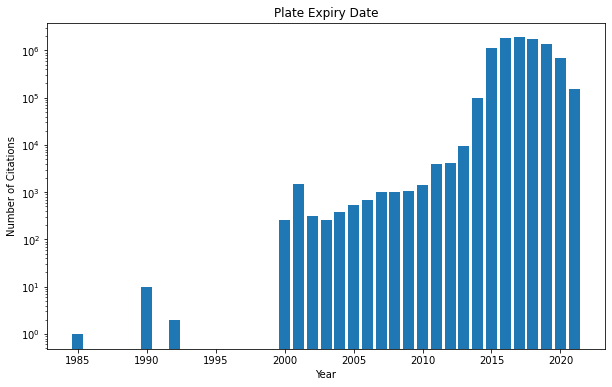

In [35]:
plate_expiry = df['Plate Expiry Date Parsed'].dt.year.value_counts().sort_index()
plt.figure(figsize=(10 ,6))
plt.bar(plate_expiry.index, plate_expiry)
plt.title('Plate Expiry Date')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.yscale('log')
plt.show()

The early dates are kept because it seems very plausible that there are people driving around with expired plates.

In [36]:
df.loc[df['Plate Expiry Date Parsed'].notna()]

Ticket number Meter Id  ...            Datetime Plate Expiry Date Parsed
0           1103341116      NaN  ... 2015-12-21 12:51:00               2003-04-01
1           1103700150      NaN  ... 2015-12-21 14:35:00               2015-12-01
2           1104803000      NaN  ... 2015-12-21 20:55:00               2015-03-01
5           1106226590      NaN  ... 2015-09-15 00:19:00               2015-07-01
6           1106500452      NaN  ... 2015-12-17 17:10:00               2016-05-01
...                ...      ...  ...                 ...                      ...
10634304    4517245261      NaN  ... 2020-09-10 23:20:00               2020-12-01
10634305    4517797760      NaN  ... 2020-09-10 23:11:00               2021-03-01
10634306    4517639431      NaN  ... 2020-09-10 23:11:00               2020-11-01
10634307    4517639803      NaN  ... 2020-09-10 23:10:00               2021-06-01
10634308    4517910493      NaN  ... 2020-09-10 23:00:00               2021-03-01

[8997665 rows x 22 columns]

In [37]:
# Subtract plate expiry date from current date
df['days_expired'] = (df.Datetime - df['Plate Expiry Date Parsed']).dt.days
expiry_viol_table = pd.concat([df.loc[df['days_expired'] > 0, 'Violation Description'].value_counts().reset_index()[:10],
          df['Violation Description'].value_counts().reset_index()[:10]], axis=1)
expiry_viol_table.columns = ['positive_days_expired_viol', 'violation_count', 'all', 'violation_count']

In [38]:
# Table of top 10 violations for subset of data with expired car registration vs
# Top 10 of all citation violations
expiry_viol_table

positive_days_expired_viol  ...  violation_count
0            DISPLAY OF TABS  ...          2959030
1       NO PARK/STREET CLEAN  ...          1883181
2                 METER EXP.  ...           855144
3                   RED ZONE  ...           747436
4         NO EVIDENCE OF REG  ...           623400
5       PREFERENTIAL PARKING  ...           470942
6                 NO PARKING  ...           291099
7          DISPLAY OF PLATES  ...           231284
8            EXCEED 72HRS-ST  ...           207005
9     PARKED OVER TIME LIMIT  ...           189268

[10 rows x 4 columns]

In the table above, it would seem that if the difference between the citation date and the expiry date was positive, it would more likely be cited as a "DISPLAY OF TABS" violation. This could also explain why there are so many empty entries--officers are more likely to input this if their registration is expired.

In [39]:
df.VIN.unique()[:100]

array([nan, '3225', '1068', '4286', '4683', '6904', '8788', '1856',
       '5884', '3427', '1655', '3266', '3490', '3980', '0277', '2850',
       '9233', '3019', '1153', '7978', '4608', '2807', '3687', '8628',
       '2016', '8835', '4889', '7344', '5302', '5534', '7323', '4434',
       '3N1BB41D5XL003388', '4151', '3931', '0645', '2674', '3391',
       '6412', '6768', '4871', '9864', '6333', '3757', '2785', '4253',
       '9315', '5364', '0962', '9207', '6086', '1598', '0285', '9446',
       '5090', '5261', '6638', '1376', '9698', '3554', '8784', '2917',
       '7981', '5512', '9995', '0156', '1HGCR2F57EA225553', '8917',
       '7320', '3949', '5028', '2567', '3928', '0365', '4008', '8096',
       '8619', '7466', '8001', '1048', '2433', '6969', '6523', '6073',
       'ZAMCE39A760021282', '3278', '7573', '8326', '1270', '0468',
       '7995', 'WBA3C1C9FK118236', '1254', '8908', '7187', '1348', '7760',
       '1010', '4498', '5620'], dtype=object)

In [40]:
df.loc[df.VIN.str.len() > 4, 'VIN']

888184    3N1BB41D5XL003388
888278    1HGCR2F57EA225553
888302    ZAMCE39A760021282
888309     WBA3C1C9FK118236
888366    JTDKN3DUID1650769
                ...        
925907              COVERED
925909              COVERED
925914              COVERED
925915    JTHBW1GGXF2080614
925929    1N4AL3AP2EN224587
Name: VIN, Length: 3558, dtype: object

In [41]:
df[df.VIN == '1N4AL3AP2EN224587']

Ticket number Meter Id  ...  Plate Expiry Date Parsed days_expired
925929    4247320195  CB3067A  ...                       NaT          NaN

[1 rows x 23 columns]

In [42]:
df.loc[df.VIN.str.len() > 4, 'Datetime'].dt.year.value_counts()

2014    3558
Name: Datetime, dtype: int64

Most of these VIN records are missing but of the ones that aren't missing, they consist of 4 numbers. Of the ones that are not 4 numbers, there are some that say "COVERED", or actual plausible VIN numbers. Web VIN lookup verifies that this VIN number seems to be correct. In fact, this car was cited the same year it was manufactured. Looking at the dates where we have full VIN numbers, which are all in 2014. VIN numbers are highly identifying information. It is possible that the process of deidentification did not properly take place in 2014.

In [43]:
df.Make.value_counts()[:50]

TOYT    1754263
HOND    1199247
FORD     919817
NISS     764969
CHEV     725520
BMW      487421
MERZ     436098
VOLK     357818
HYUN     328395
DODG     314900
LEXS     301184
KIA      257336
JEEP     251242
AUDI     207049
MAZD     195080
OTHR     174866
GMC      152123
INFI     139825
CHRY     134649
ACUR     126086
SUBA     120087
VOLV      99880
TOYO      96548
MITS      88861
CADI      83447
MNNI      74685
LNDR      62775
PORS      55563
UNK       51774
FRHT      49595
BUIC      49343
LINC      45221
PONT      44896
GRUM      43619
STRN      41773
FIAT      39025
TSMR      34829
JAGU      32419
MERC      29541
RROV      21709
ISU       20938
INTL      17875
SUZI      14143
SAA       12968
OLDS      12199
LEXU      11494
MASE      11288
PTRB       7827
PLYM       7095
KW         6519
Name: Make, dtype: int64

In [45]:
df.groupby('Make')['Fine amount'].agg('sum').sort_values(ascending=False)

Make
TOYT    124205230.0
HOND     84420894.0
FORD     65176449.0
NISS     54803897.0
CHEV     51668206.0
           ...     
HSCE            0.0
HRTL            0.0
HRII            0.0
HRA             0.0
.               0.0
Name: Fine amount, Length: 2557, dtype: float64

In [46]:
make_vio_dict = {}
for make in df.Make.value_counts().index:
  counts = df.loc[(df.Make == make)& (df.Make.notna()), 'Violation Description'].value_counts()
  count_ratio = counts/counts.sum()
  make_vio_dict[make] = count_ratio.to_dict()
make_ratio = pd.DataFrame.from_dict(make_vio_dict).T
#make_ratio = make_ratio.drop(['OTHR', 'TOYO', 'MERC', 'UNK'])

In [59]:
make_ratio.index

Index(['TOYT', 'HOND', 'FORD', 'NISS', 'CHEV', 'BMW', 'MERZ', 'VOLK', 'HYUN',
       'DODG',
       ...
       'PEOP', 'CURB', 'RROH', 'ROBV', 'GRSH', 'MET', 'SUIU', 'STIN', 'WABG',
       'LEGD'],
      dtype='object', length=2557)

In [87]:
len(make_ratio)

2557

In [75]:
make_ratio

NO PARK/STREET CLEAN  METER EXP.  ...  80691E  80671O
TOYT              0.313660    0.185057  ...     0.0     0.0
HOND              0.313924    0.162358  ...     0.0     0.0
FORD              0.289905    0.148375  ...     0.0     0.0
NISS              0.293974    0.160401  ...     0.0     0.0
CHEV              0.281319    0.147703  ...     0.0     0.0
...                    ...         ...  ...     ...     ...
MET               0.000000    0.000000  ...     0.0     0.0
SUIU              0.000000    0.000000  ...     0.0     0.0
STIN              0.000000    0.000000  ...     0.0     0.0
WABG              0.000000    0.000000  ...     0.0     0.0
LEGD              0.000000    0.000000  ...     0.0     0.0

[2557 rows x 208 columns]

In [103]:
make_ratio = make_ratio.loc[df.Make.value_counts()[:50].index]
make_ratio = make_ratio.fillna(0)

In [104]:
make_ratio.style.background_gradient(cmap='Blues').format("{:.3f}")

In [105]:
# 2-component PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(make_ratio)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'], index = make_ratio.index)

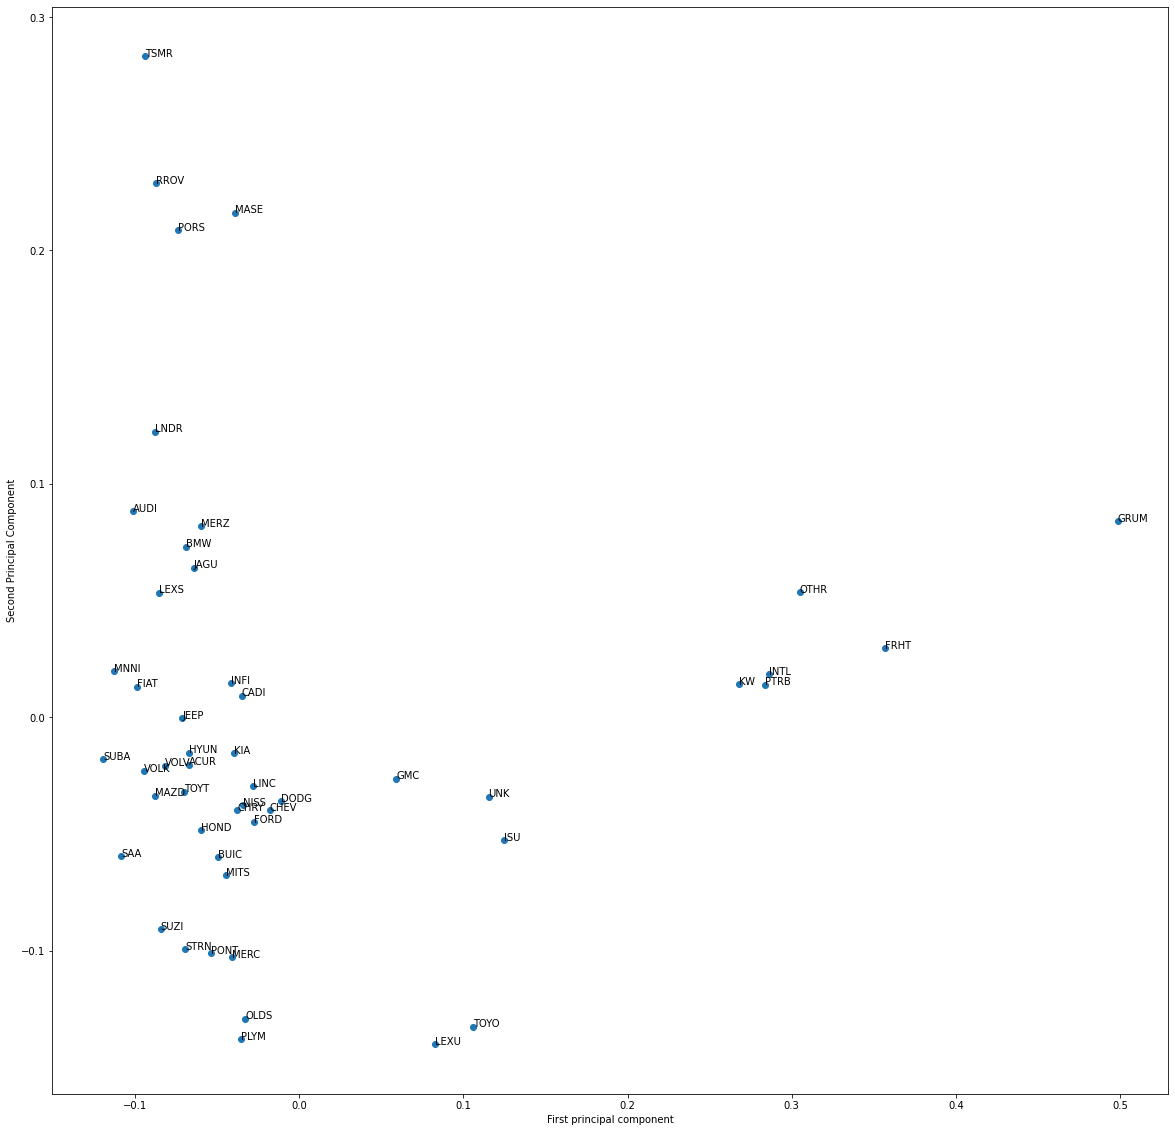

In [106]:
# PCA 2-component plot
plt.figure(figsize=(20,20))
plt.scatter(principalDf.iloc[:,0],principalDf.iloc[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
for i, txt in enumerate(principalDf.index):
    plt.annotate(txt, (principalDf.iloc[i,0], principalDf.iloc[i,1]), fontsize=10 )
plt.show()


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.001s...
[t-SNE] Computed neighbors for 50 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.026697
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.693535
[t-SNE] KL divergence after 1000 iterations: 0.210191


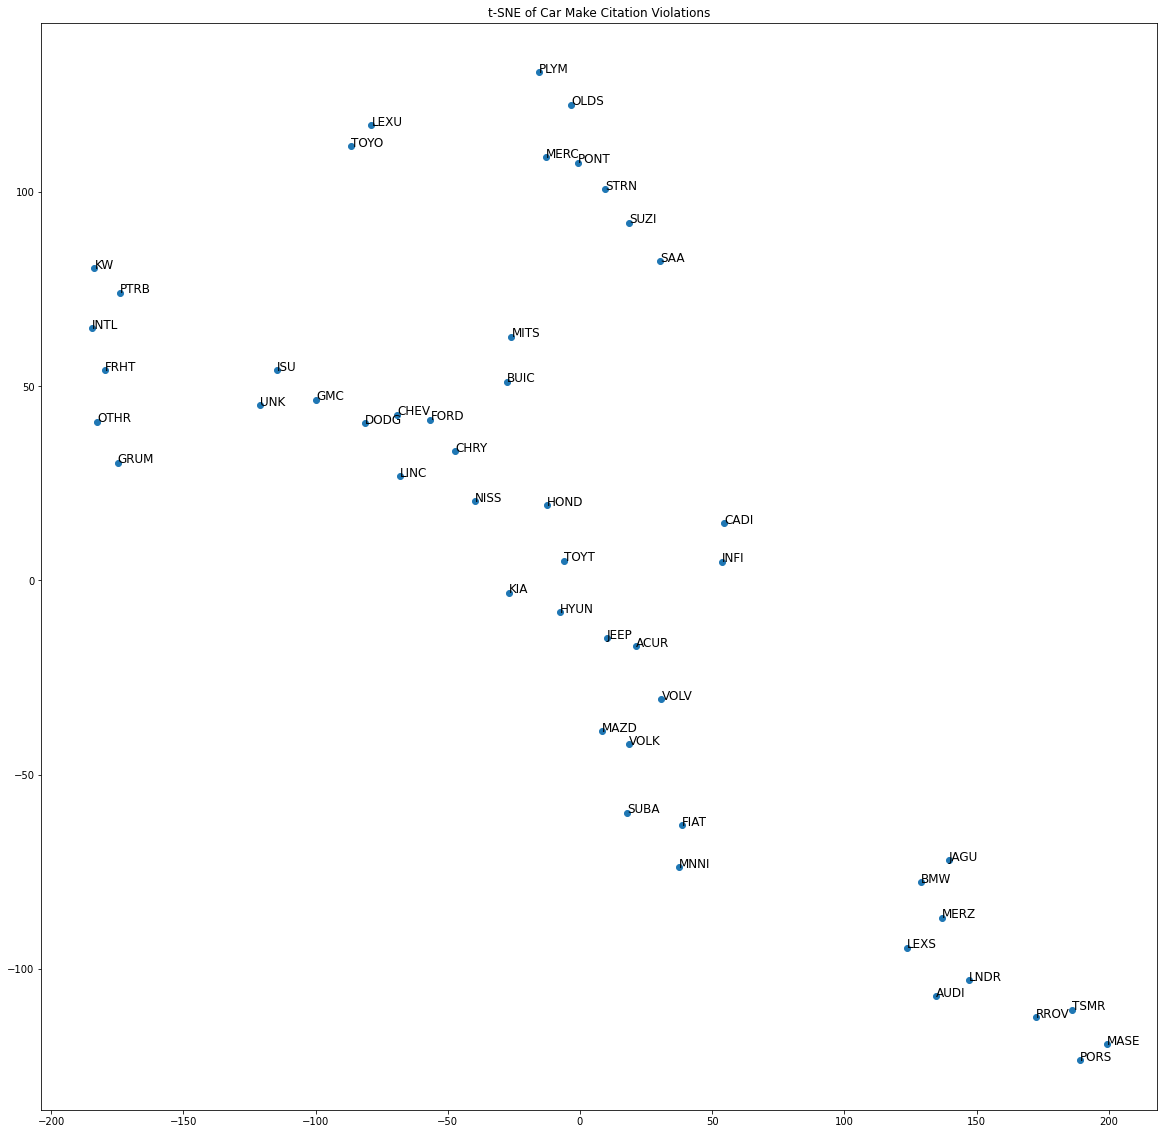

In [107]:
# t-distributed Stochastic Neighbor Embedding
tsne = TSNE(verbose=1, perplexity=5, random_state=42)
X_embedded = tsne.fit_transform(make_ratio.to_numpy())
plt.figure(figsize=(20,20))

# t-SNE Plot
plt.scatter(X_embedded[:,0], X_embedded[:,1])
for i, txt in enumerate(principalDf.index):
    plt.annotate(txt, (X_embedded[i,0], X_embedded[i,1]), fontsize=12 )
plt.title('t-SNE of Car Make Citation Violations')
plt.show()

In [82]:
bdy_style_vio_dict = {}
for style in df['Body Style'].value_counts().head(15).index:
  counts = df.loc[(df['Body Style'] == style)& (df['Body Style'].notna()), 'Violation Description'].value_counts()
  count_ratio = counts/counts.sum()
  bdy_style_vio_dict[style] = count_ratio.to_dict()
bdy_style_ratio = pd.DataFrame.from_dict(bdy_style_vio_dict).T

In [83]:
bdy_style_ratio = bdy_style_ratio.fillna(0)

In [84]:
bdy_style_ratio.style.background_gradient(cmap='Blues').format("{:.3f}")

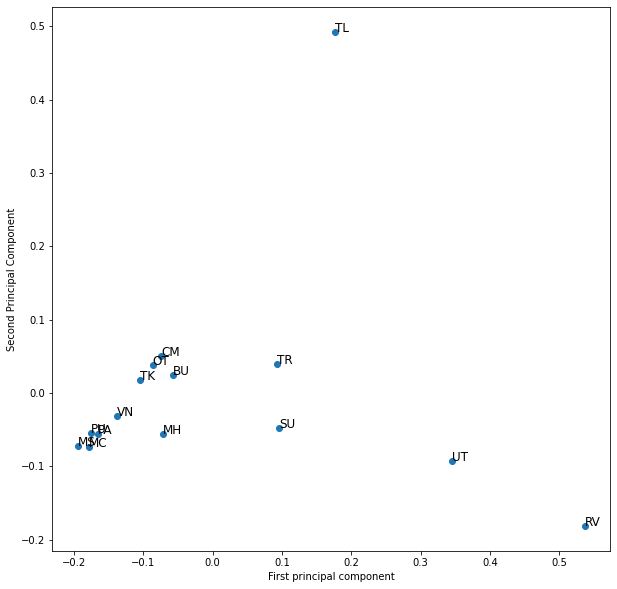

In [85]:
pca_body = PCA(n_components=2)
principalComponents_body = pca.fit_transform(bdy_style_ratio)
principalDf_body = pd.DataFrame(data = principalComponents_body
             , columns = ['principal component 1', 'principal component 2'], index = bdy_style_ratio.index)
# PCA 2-component plot
plt.figure(figsize=(10 ,10))
plt.scatter(principalDf_body.iloc[:,0],principalDf_body.iloc[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
for i, txt in enumerate(principalDf_body.index):
    plt.annotate(txt, (principalDf_body.iloc[i,0], principalDf_body.iloc[i,1]), fontsize=12 )
plt.show()
